In [851]:
import sys
import os

# 获取当前 notebook 所在目录的父目录
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from gbp.gbp import *
from gbp.factor import *
from gbp.grid import *
import matplotlib.pyplot as plt



@jax.jit
def h3_fn_tilde(x, B, k):
    """
    Predicts measurement h(x) for abs prior.

    Input:
        x: (2,) → 2D abstraction of 4 stacked fine-level variables
        B: (8,2) → projection matrix from 2D to 8D
    Output:
        z_hat: (16,) = [x0, x1, x2, x3, x1-x0, x2-x0, x3-x1, x3-x2]
    """

    x = x.reshape(-1)
    B = B.reshape(8, -1)  # Ensure B is the correct shape
    k = k.reshape(-1)  # Ensure k is the correct shape

    x = B @ x + k  # Project 2D abstraction to 8D
    
    x0 = x[0:2]
    x1 = x[2:4]
    x2 = x[4:6]
    x3 = x[6:8]

    # 4 priors (just xi)
    z_hat_0 = x0
    z_hat_1 = x1
    z_hat_2 = x2
    z_hat_3 = x3

    # 4 internal between
    z_hat_4 = x1 - x0
    z_hat_5 = x2 - x0
    z_hat_6 = x3 - x1
    z_hat_7 = x3 - x2

    return jnp.concatenate([
        z_hat_0, z_hat_1, z_hat_2, z_hat_3,
        z_hat_4, z_hat_5, z_hat_6, z_hat_7
    ])


@jax.jit
def h4_fn_tilde(xs, Bs, ks):
    """
    Predicts coarse between measurement h(xs) where:
      - xs[0] is coarse variable i (8D)
      - xs[1] is coarse variable j (8D)
    Fixed: uses v01→v02 and v11→v12 edges
    
    Returns:
        z_hat: shape (4,) = two 2D relative positions
    """
    xi = xs[0]
    xj = xs[1]
    Bi = Bs[0]
    Bj = Bs[1]
    ki = ks[0]
    kj = ks[1]

    # Project coarse variables to 8D
    xi = Bi @ xi + ki  # shape (8,)
    xj = Bj @ xj + kj  # shape (8,)

    # First residual: xj[0:2] - xi[2:4]  (v02 - v01)
    r1 = xj[0:2] - xi[2:4]

    # Second residual: xj[4:6] - xi[6:8] (v12 - v11)
    r2 = xj[4:6] - xi[6:8]

    return jnp.concatenate([r1, r2])  # shape (4,)


@jax.jit
def h5_fn_tilde(xs, Bs, ks):
    """
    Predicts coarse between measurement h(xs) where:
      - xs[0] is coarse variable i (8D)
      - xs[1] is coarse variable j (8D)
    Fixed: uses v10→v20 and v11→v21 edges

    Returns:
        z_hat: shape (4,) = two 2D relative positions
    """
    xi = xs[0]
    xj = xs[1]
    Bi = Bs[0]
    Bj = Bs[1]
    ki = ks[0]
    kj = ks[1]


    # Project coarse variables to 8D
    xi = Bi @ xi + ki  # shape (8,)
    xj = Bj @ xj + kj # shape (8,)  

    # First residual: xj[0:2] - xi[4:6]  (v20 - v10)
    r1 = xj[0:2] - xi[4:6]

    # Second residual: xj[2:4] - xi[6:8] (v21 - v11)
    r2 = xj[2:4] - xi[6:8]

    return jnp.concatenate([r1, r2])  # shape (4,)


@partial(jax.jit, static_argnames=["h_fn", "w"])
def factor_update_tilde(factor, xs, Bs, ks, h_fn, w):
    h = h_fn(xs, Bs, ks)  # <== 传入常量
    J = jax.jacrev(h_fn, argnums=0)(xs, Bs, ks).reshape(h.size, xs.size)  # 只对 xs 求导


    z = factor.z
    z_Lam = factor.z_Lam

    r = z - h.reshape(-1)
    s = w(r.T @ z_Lam @ r, factor.threshold)
    Lam = s * J.T @ z_Lam @ J
    eta = s * J.T @ z_Lam @ (J @ xs.reshape(-1) + r)
    return Gaussian(eta, Lam)


@partial(jax.jit, static_argnames=["h_fn", "w"])
def update_factor_tilde(facs, varis, vtof_msgs, linpoints, Bs, ks, h_fn, w):
    vtof_msgs_reordered = jax.tree_util.tree_map(
        lambda x: x[facs.adj_var_id, facs.adj_var_idx], vtof_msgs
    )
    linpoints_reordered = jax.tree_util.tree_map(
        lambda x: x[facs.adj_var_id], linpoints
    )

    Bs_reordered = jax.tree_util.tree_map(
        lambda x: x[facs.adj_var_id], Bs
    )

    ks_reordered = jax.tree_util.tree_map(
        lambda x: x[facs.adj_var_id], ks
    )

    # If shape is (N, 1, D), squeeze to (N, D)
    if linpoints_reordered.ndim == 3 and linpoints_reordered.shape[1] == 1:
        linpoints_reordered = linpoints_reordered.squeeze(1)
        Bs_reordered = Bs_reordered.squeeze(1)
        ks_reordered = ks_reordered.squeeze(1)
    

    facs.potential = jax.vmap(
        factor_update_tilde, in_axes=(0, 0, 0, 0, None, None)  # constant vmap in 0-th axis
    )(facs, linpoints_reordered, Bs_reordered, ks_reordered, h_fn, w)

    ftov_msgs = jax.vmap(compute_ftov_msg)(facs, vtof_msgs_reordered)

    varis.msgs.eta = varis.msgs.eta.at[facs.adj_var_id, facs.adj_var_idx].set(ftov_msgs.eta)
    varis.msgs.Lam = varis.msgs.Lam.at[facs.adj_var_id, facs.adj_var_idx].set(ftov_msgs.Lam)

    mask = (varis.adj_factor_idx >= 0)[..., None]
    varis.msgs.eta = varis.msgs.eta * mask
    varis.msgs.Lam = varis.msgs.Lam * mask[..., None]

    return facs, varis


In [852]:
def build_abs_slam_graph(
    varis_sup: Variable,
    prior_facs_sup: Factor,
    horizontal_facs_sup: Factor,
    vertical_facs_sup: Factor,
) -> Tuple[Variable, Factor, Factor]:

    abs_beliefs = []
    abs_msgs_eta = []
    abs_msgs_Lam = []
    abs_adj_factor_idx = []
    Bs = []
    ks = []

    # === 1. Build Abstraction Variables ===
    varis_sup_mu = varis_sup.belief.mu()
    varis_sup_sigma = varis_sup.belief.sigma()

    for i in range(len(varis_sup.var_id)):
        varis_sup_mu_i = varis_sup_mu[i]
        varis_sup_sigma_i = varis_sup_sigma[i]

        eigvals, eigvecs = np.linalg.eigh(varis_sup_sigma_i)

        # Step 2: Sort eigenvalues and eigenvectors in descending order of eigenvalues
        idx = np.argsort(eigvals)[::-1]      # Get indices of sorted eigenvalues (largest first)
        eigvals = eigvals[idx]               # Reorder eigenvalues
        eigvecs = eigvecs[:, idx]            # Reorder corresponding eigenvectors

        # Step 3: Select the top-k eigenvectors to form the projection matrix (principal subspace)
        r = 2
        B_reduced = eigvecs[:, :r]                 # B_reduced: shape (8, r), projects 8D to rD

        Bs.append(B_reduced)                        # Store the projection matrix for this variable

        # Step 4: Project eta and Lam onto the reduced 2D subspace
        # This gives the natural parameters of the reduced 2D Gaussian
        varis_abs_mu_i = B_reduced.T @ varis_sup_mu_i          # Projected natural mean: shape (2,)
        varis_abs_sigma_i = B_reduced.T @ varis_sup_sigma_i @ B_reduced  # Projected covariance: shape (2, 2)
        ks.append(varis_sup_mu_i - B_reduced @ varis_abs_mu_i)  # Store the offset for this variable

        varis_abs_lam_i = jnp.linalg.inv(varis_abs_sigma_i)  # Inverse covariance (precision matrix): shape (2, 2)
        varis_abs_eta_i = varis_abs_lam_i @ varis_abs_mu_i  # Natural parameters: shape (2,)
        abs_beliefs.append(Gaussian(varis_abs_eta_i, varis_abs_lam_i))


    N, Ni_v, _ = varis_sup.msgs.eta.shape
    abs_msgs = Gaussian(jnp.zeros((N, Ni_v, r)), jnp.zeros((N, Ni_v, r, r)))  # messages (eta, Lambda) to each factor port

    varis_abs = Variable(
        var_id=varis_sup.var_id,
        belief=tree_stack(abs_beliefs, axis=0),
        msgs=abs_msgs,
        adj_factor_idx=jnp.stack(varis_sup.adj_factor_idx),
    )

    # === 2. Build Abs Priors ===
    prior_facs_abs = Factor(
        factor_id=prior_facs_sup.factor_id,
        z=prior_facs_sup.z,
        z_Lam=prior_facs_sup.z_Lam,
        threshold=prior_facs_sup.threshold,
        potential=None,
        adj_var_id=prior_facs_sup.adj_var_id,
        adj_var_idx=prior_facs_sup.adj_var_idx,
    )

    # === Build Horizontal & Vertical Between Factors Separately ===
    horizontal_facs_abs = Factor(
        factor_id=horizontal_facs_sup.factor_id,
        z= horizontal_facs_sup.z,
        z_Lam= horizontal_facs_sup.z_Lam,
        threshold= horizontal_facs_sup.threshold,
        potential=None,
        adj_var_id= horizontal_facs_sup.adj_var_id,
        adj_var_idx= horizontal_facs_sup.adj_var_idx,
    )   

    vertical_facs_abs = Factor(
        factor_id=vertical_facs_sup.factor_id,
        z= vertical_facs_sup.z,
        z_Lam= vertical_facs_sup.z_Lam,
        threshold= vertical_facs_sup.threshold,
        potential=None,                                         
        adj_var_id= vertical_facs_sup.adj_var_id,
        adj_var_idx= vertical_facs_sup.adj_var_idx,
    )

    return varis_abs, prior_facs_abs, horizontal_facs_abs, vertical_facs_abs, jnp.asarray(Bs), jnp.asarray(ks)

In [853]:
H = 16
W = 16
prior_noise_std=prior_std=1
odom_noise_std=odom_std=0.01
seed=0
num_iters=100


positions, prior_meas, between_meas = generate_grid_slam_data(H=H, W=W, 
                                    prior_noise_std=prior_noise_std, odom_noise_std=odom_noise_std, seed=seed)

#prior_meas = [(i, [0, 0]) for i, _ in prior_meas]

varis, prior_facs, between_facs = build_pose_slam_graph(N=256, prior_meas=prior_meas, between_meas=between_meas, 
                                                        prior_std=prior_std, odom_std=odom_std,
                                                        Ni_v=10, D=2)


# build the coarse-level pose SLAM grid
varis_sup, prior_facs_sup, horizontal_facs_sup, vertical_facs_sup  = build_coarse_slam_graph(
    prior_facs_fine=prior_facs,
    between_facs_fine=between_facs,
    H=H, W=W,
    stride = 2,
)


# Variable update
varis_sup, vtof_msgs, linpoints = update_variable(varis_sup)

# Unary factor Update
prior_facs, varis_sup = update_factor(prior_facs_sup, varis_sup, vtof_msgs, linpoints, h3_fn, l2)

# Variable update
varis_sup, vtof_msgs, linpoints = update_variable(varis_sup)


# Binary factor update
#horizontal_facs_sup, varis_sup = update_factor(horizontal_facs_sup, varis_sup, vtof_msgs, 
#                                                linpoints, h4_fn, l2)

#vertical_facs_sup, varis_sup = update_factor(vertical_facs_sup, varis_sup, vtof_msgs, 
#                                                linpoints, h5_fn, l2)


# Variable update
varis_sup, vtof_msgs, linpoints = update_variable(varis_sup)

In [854]:
sup_iterations = 0  # Number of iterations for the abstraction recovery

for i in range(sup_iterations):
    # Unary factor Update
    prior_facs, varis_sup = update_factor(prior_facs_sup, varis_sup, vtof_msgs, linpoints, h3_fn, l2)
    # Binary factor update
    horizontal_facs_sup, varis_sup = update_factor(horizontal_facs_sup, varis_sup, vtof_msgs, 
                                                    linpoints, h4_fn, l2)
    vertical_facs_sup, varis_sup = update_factor(vertical_facs_sup, varis_sup, vtof_msgs, 
                                                    linpoints, h5_fn, l2)

    # Variable update
    varis_sup, vtof_msgs, linpoints = update_variable(varis_sup)

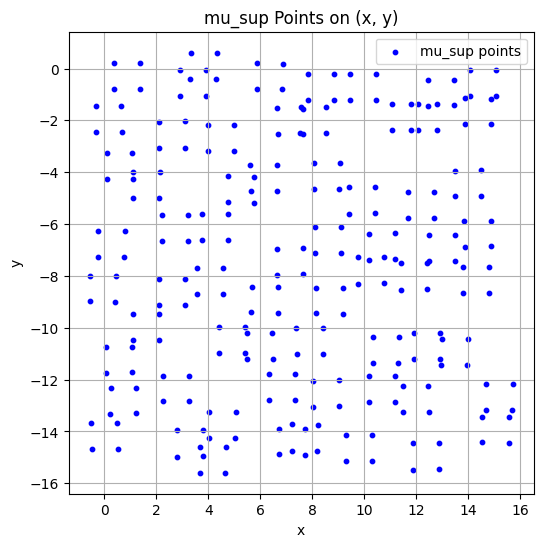

In [855]:
a = varis_sup.belief.mu().reshape (64,4,2)
a = a.reshape(-1,2)

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(a[:, 0], a[:, 1], c='blue', label='mu_sup points', s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.title("mu_sup Points on (x, y)")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.savefig("1.png", dpi=300)

In [856]:
varis_abs, prior_facs_abs, horizontal_facs_abs, vertical_facs_abs, Bs, ks = build_abs_slam_graph(
    varis_sup=varis_sup,
    prior_facs_sup=prior_facs_sup,
    horizontal_facs_sup=horizontal_facs_sup,
    vertical_facs_sup=vertical_facs_sup,
)

# Step 1: Variable update
varis_abs, vtof_msgs, linpoints = update_variable(varis_abs)

# Factor update
prior_facs_abs, varis_abs = update_factor_tilde(prior_facs_abs, varis_abs, vtof_msgs, linpoints, Bs, ks, h3_fn_tilde, l2)


varis_abs, vtof_msgs, linpoints = update_variable(varis_abs)


# Factor update
horizontal_facs_abs, varis_abs = update_factor_tilde(horizontal_facs_abs, varis_abs, vtof_msgs, 
                                                linpoints, Bs, ks, h4_fn_tilde, l2)

vertical_facs_abs, varis_abs = update_factor_tilde(vertical_facs_abs, varis_abs, vtof_msgs, 
                                                linpoints, Bs, ks, h5_fn_tilde, l2)

# Variable update
varis_abs, vtof_msgs, linpoints = update_variable(varis_abs)



In [857]:
for i in range(1000):
    # Factor update
    prior_facs_abs, varis_abs = update_factor_tilde(prior_facs_abs, varis_abs, vtof_msgs, linpoints, Bs, ks, h3_fn_tilde, l2)

    horizontal_facs_abs, varis_abs = update_factor_tilde(horizontal_facs_abs, varis_abs, vtof_msgs, 
                                                linpoints, Bs, ks, h4_fn_tilde, l2)

    vertical_facs_abs, varis_abs = update_factor_tilde(vertical_facs_abs, varis_abs, vtof_msgs, 
                                                linpoints, Bs, ks, h5_fn_tilde, l2)

    # Variable update 
    varis_abs, vtof_msgs, linpoints = update_variable(varis_abs)

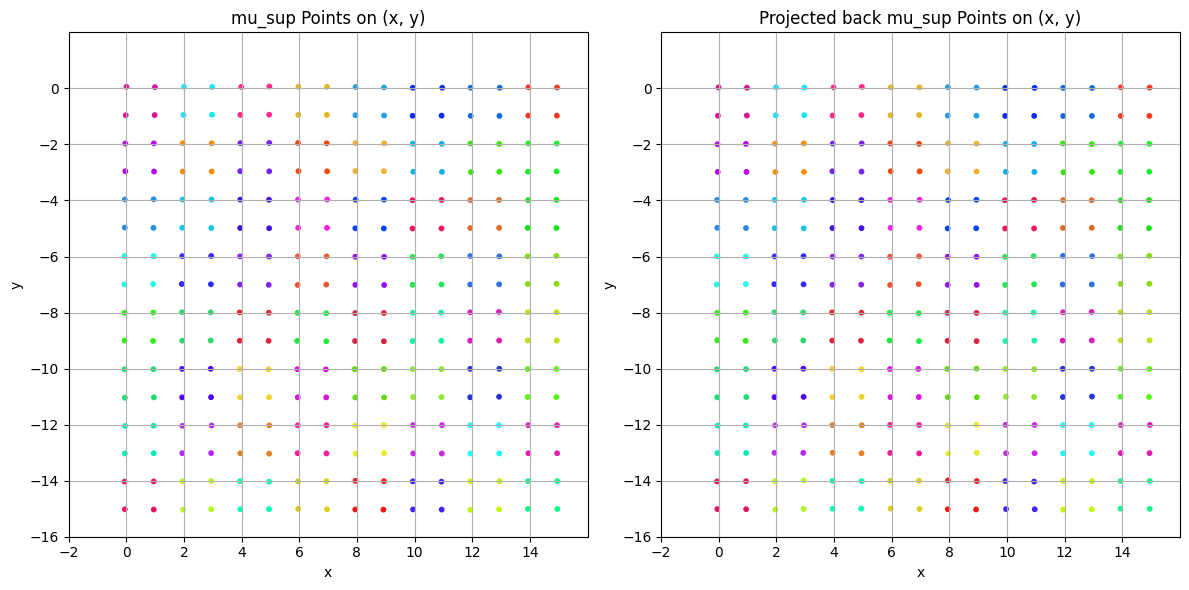

In [861]:
import random
import colorsys

# Get the belief mean from varis_sup and reshape:
# Original shape: (64, 4, 2) — 64 groups, each with 4 points (forming a square)
# Flatten to (256, 2)
a = varis_sup.belief.mu().reshape(64, 4, 2).reshape(-1, 2)

# Get the belief mean from varis_abs
mu_abs = varis_abs.belief.mu()

# Project each 8D variable (mu_abs[i]) back to 4 sets of 2D points
# using the stored projection matrix Bs[i] and translation ks[i]
mu_sup = []
for i in range(len(mu_abs)):
    points = Bs[i] @ mu_abs[i] + ks[i]  # shape (8,)
    mu_sup.append(points[0:2])
    mu_sup.append(points[2:4])
    mu_sup.append(points[4:6])
    mu_sup.append(points[6:8])
mu_sup = jnp.stack(mu_sup)  # shape (256, 2)

# -------- Generate 64 vivid and random colors --------
def generate_random_vivid_colors(n):
    """
    Generate n vivid RGB colors by sampling evenly in HSV color space,
    then shuffling the hue values to make them appear random.
    Saturation and brightness are fixed at high values.
    """
    hsv_colors = [(i / n, random.uniform(0.8, 1.0), random.uniform(0.85, 1.0)) for i in range(n)]

    np.random.shuffle(hsv_colors)  # Randomize hue order
    rgb_colors = [colorsys.hsv_to_rgb(*hsv) for hsv in hsv_colors]
    return rgb_colors

# Generate 64 colors and repeat each one 4 times (one color per 4-point square)
colors = generate_random_vivid_colors(64)
point_colors = np.repeat(colors, 4, axis=0)

# -------- Plotting --------
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Left plot: original mu_sup from varis_sup
axs[0].scatter(a[:, 0], a[:, 1], c=point_colors, s=10)
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_title("mu_sup Points on (x, y)")
axs[0].grid(True)

# Right plot: projected-back mu_sup from varis_abs
axs[1].scatter(mu_sup[:, 0], mu_sup[:, 1], c=point_colors, s=10)
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_title("Projected back mu_sup Points on (x, y)")
axs[1].grid(True)

# Set consistent axis limits and ticks for comparison
for ax in axs:
    ax.set_xlim(-2, 16)
    ax.set_ylim(-16, 2)
    ax.set_xticks(range(-2, 16, 2))
    ax.set_yticks(range(-16, 2, 2))

# Optimize layout and save figure
plt.tight_layout()
plt.savefig("comparison_random_vivid.png", dpi=400)


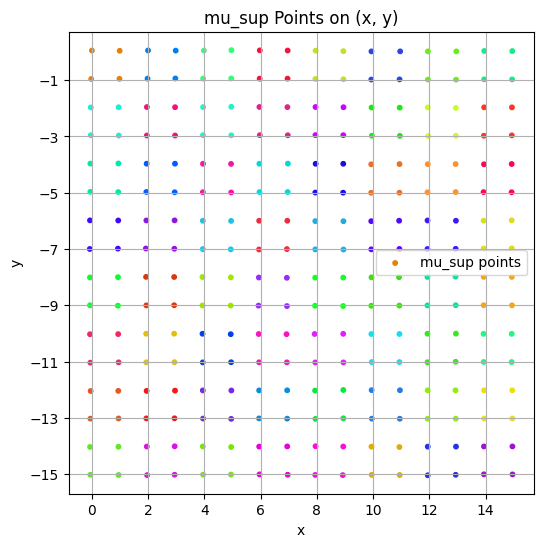

In [ ]:
sup_iterations = 1000  # Number of iterations for the abstraction recovery

for i in range(sup_iterations):
    # Variable update
    varis_sup, vtof_msgs, linpoints = update_variable(varis_sup)

    # Unary factor Update
    prior_facs, varis_sup = update_factor(prior_facs_sup, varis_sup, vtof_msgs, linpoints, h3_fn, l2)
    # Binary factor update
    horizontal_facs_sup, varis_sup = update_factor(horizontal_facs_sup, varis_sup, vtof_msgs, 
                                                    linpoints, h4_fn, l2)
    vertical_facs_sup, varis_sup = update_factor(vertical_facs_sup, varis_sup, vtof_msgs, 
                                                    linpoints, h5_fn, l2)

    # Variable update
    varis_sup, vtof_msgs, linpoints = update_variable(varis_sup)

b = varis_sup.belief.mu().reshape (64,4,2)
b = b.reshape(-1,2)

plt.figure(figsize=(6, 6))
plt.scatter(b[:, 0], b[:, 1], c=point_colors, label='mu_sup points', s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-2, 16)
plt.ylim(-16, 2)
plt.xticks(range(-2, 16, 2))
plt.yticks(range(-17, 2, 2))
plt.title("mu_sup Points on (x, y)")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.savefig("1.png", dpi=400)

In [860]:
average_position_error = 0
for i in range(256):
    average_position_error += np.linalg.norm(mu_sup[i]-b[i])

average_position_error /=256
print(average_position_error)


0.7077721159439534
